In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/merchants-analysis/analyze_me.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score

In [4]:
orders = pd.read_csv('../input/merchants-analysis/analyze_me.csv')
orders

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,1360750,378035,151467,bicycle,Five Guys Burgers and Fries,Burger,Cheeseburger,1.0,Burgers,NaN,40.804404,-73.966430,40.818637,-73.939241,2014-10-14 13:30:25.567577,2014-10-14 13:41:09.42809,2014-10-14 13:53:28.264588,2014-10-14 14:10:19.256853
5979,1348697,96943,3296,bicycle,Cafe Mogador,Middle Eastern,Vegetarian,1.0,Cous Cous,NaN,40.727293,-73.984517,40.725938,-73.980550,2014-10-12 18:37:42.565897,2014-10-12 18:44:21.331886,2014-10-12 18:54:16.442017,2014-10-12 19:00:43.047785
5980,1274438,355090,153113,bicycle,Shake Shack,Burger,Fries,1.0,Fries,NaN,40.780826,-73.976483,40.763573,-73.973503,2014-10-01 18:12:56.973655,2014-10-01 18:29:59.803516,2014-10-01 18:52:19.769244,2014-10-01 19:16:52.653179
5981,1470282,400983,142140,car,Omai,Vietnamese,Ca Tim,1.0,Appetizers,00:02:17.264098,40.744408,-74.002891,40.734609,-74.006405,2014-10-27 20:25:03.592287,2014-10-27 20:22:37.822461,2014-10-27 20:39:25.770399,2014-10-27 20:50:45.259345


In [5]:
#check datatypes
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [6]:
orders.describe()

,delivery_id,customer_id,jumpman_id,item_quantity,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
count,5.983000e+03,5983.000000,5983.000000,4753.000000,5983.000000,5983.000000,5983.000000,5983.000000
mean,1.379495e+06,176472.595521,102661.602541,1.248264,40.741425,-73.987101,40.744216,-73.985765
std,6.459397e+04,116414.487842,48607.211795,0.785904,0.022833,0.014896,0.025251,0.018060
min,1.271706e+06,242.000000,3296.000000,1.000000,40.665611,-74.015837,40.649356,-74.017679
25%,1.322792e+06,77817.000000,60761.000000,1.000000,40.724340,-73.996630,40.725307,-74.000297
50%,1.375689e+06,131093.000000,113364.000000,1.000000,40.735677,-73.988682,40.740424,-73.989280
75%,1.436371e+06,293381.000000,143807.000000,1.000000,40.758726,-73.980739,40.763885,-73.974696
max,1.491424e+06,405547.000000,181543.000000,16.000000,40.818082,-73.920980,40.848324,-73.924124


In [7]:
#checking primary key
orders.delivery_id.nunique()

5214

In [8]:
orders.jumpman_id.nunique()

578

In [9]:
orders.pickup_place.nunique()

898

In [10]:
orders.customer_id.nunique()

3192

In [11]:
#checking primary key
check = orders.delivery_id.value_counts()
check = check[check > 1]
len(check)

656

656 delivery_id have multiple entries, meaning there currently is no primary key 

In [12]:
orders.nunique()

delivery_id                            5214
customer_id                            3192
jumpman_id                              578
vehicle_type                              7
pickup_place                            898
place_category                           57
item_name                              2277
item_quantity                            11
item_category_name                      767
how_long_it_took_to_order              2579
pickup_lat                             1210
pickup_lon                             1179
dropoff_lat                            2841
dropoff_lon                            2839
when_the_delivery_started              5214
when_the_Jumpman_arrived_at_pickup     4719
when_the_Jumpman_left_pickup           4717
when_the_Jumpman_arrived_at_dropoff    5214
dtype: int64

In [13]:
#NaN analysis
nulls = round((orders.isnull().sum()/len(orders))*100,3)
nulls

delivery_id                             0.000
customer_id                             0.000
jumpman_id                              0.000
vehicle_type                            0.000
pickup_place                            0.000
place_category                         14.758
item_name                              20.558
item_quantity                          20.558
item_category_name                     20.558
how_long_it_took_to_order              49.223
pickup_lat                              0.000
pickup_lon                              0.000
dropoff_lat                             0.000
dropoff_lon                             0.000
when_the_delivery_started               0.000
when_the_Jumpman_arrived_at_pickup      9.193
when_the_Jumpman_left_pickup            9.193
when_the_Jumpman_arrived_at_dropoff     0.000
dtype: float64

place_category, item_name, item_quantity, item_category_name,how_long_it_took_to_order, when_the_Jumpman_arrived_at_pickup and when_the_Jumpman_left_pickup all have significant amounts of missing values 

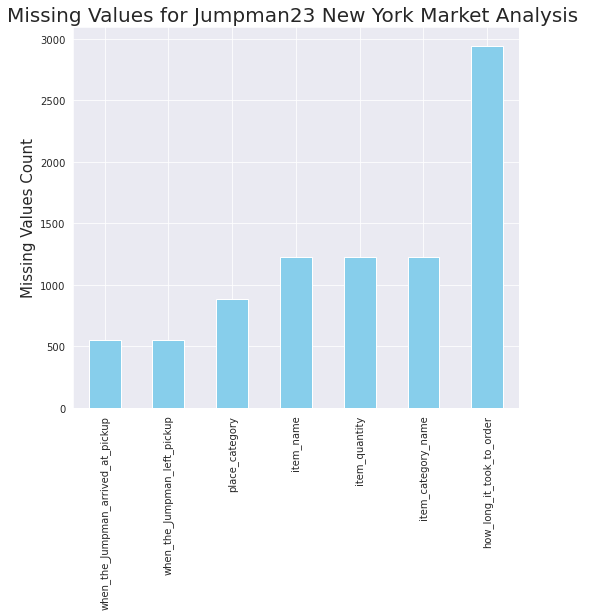

In [14]:
#NaNs 

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(8,7))
    missing = orders.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar(color='skyblue')
    plt.title("Missing Values for Jumpman23 New York Market Analysis ", fontsize=20)
    plt.ylabel("Missing Values Count", fontsize=15)

Important to understand what is causing null values - are these inputs machine generated or user inputted? If machine generated, it is worth investigating whether it was a result of a bug. Some user inputted values can be left empty if they are voluntarily inputted and not critical from a data/business perspective. 

However as part of data preprocessing and feature engineering, we will need to either impute the missing data or delete the entire variable in order to feed the data into a ml model. Generally, we impute with mean or median (or 0 depending on the context). If we decide not to impute, we'll need to decide whether to drop the rows that have missing values or delete the entire column/variable. Looking at the % missing is a helpful reference to determine this; for example since almost 50% of the data is missing for how_long_it_took_to_order, it makes sense to consider deleting the entire column before feeding the data into the ml pipeline. 

In [15]:
#convert dates from object to pd.datetime for analysis 

orders['when_the_delivery_started'] = pd.to_datetime(orders['when_the_delivery_started'])
orders['when_the_Jumpman_arrived_at_pickup'] = pd.to_datetime(orders['when_the_Jumpman_arrived_at_pickup'])
orders['when_the_Jumpman_left_pickup'] = pd.to_datetime(orders['when_the_Jumpman_left_pickup'])
orders['when_the_Jumpman_arrived_at_dropoff'] = pd.to_datetime(orders['when_the_Jumpman_arrived_at_dropoff'])


In [16]:
import datetime

date1 = orders['when_the_delivery_started']
df = pd.DataFrame(dict(date_given=date1))

df['day_of_week'] = df['date_given'].dt.weekday
print(df['day_of_week'])


0       6
1       3
2       1
3       3
4       4
       ..
5978    1
5979    6
5980    2
5981    0
5982    0
Name: day_of_week, Length: 5983, dtype: int64


In [17]:
orders = pd.concat([orders, df['day_of_week']], axis=1, sort=False)
orders

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,day_of_week
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaT,NaT,2014-10-26 14:52:06.313088,6
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,3
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.984810,2014-10-28 22:04:40.634962,1
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061,3
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,1360750,378035,151467,bicycle,Five Guys Burgers and Fries,Burger,Cheeseburger,1.0,Burgers,NaN,40.804404,-73.966430,40.818637,-73.939241,2014-10-14 13:30:25.567577,2014-10-14 13:41:09.428090,2014-10-14 13:53:28.264588,2014-10-14 14:10:19.256853,1
5979,1348697,96943,3296,bicycle,Cafe Mogador,Middle Eastern,Vegetarian,1.0,Cous Cous,NaN,40.727293,-73.984517,40.725938,-73.980550,2014-10-12 18:37:42.565897,2014-10-12 18:44:21.331886,2014-10-12 18:54:16.442017,2014-10-12 19:00:43.047785,6
5980,1274438,355090,153113,bicycle,Shake Shack,Burger,Fries,1.0,Fries,NaN,40.780826,-73.976483,40.763573,-73.973503,2014-10-01 18:12:56.973655,2014-10-01 18:29:59.803516,2014-10-01 18:52:19.769244,2014-10-01 19:16:52.653179,2
5981,1470282,400983,142140,car,Omai,Vietnamese,Ca Tim,1.0,Appetizers,00:02:17.264098,40.744408,-74.002891,40.734609,-74.006405,2014-10-27 20:25:03.592287,2014-10-27 20:22:37.822461,2014-10-27 20:39:25.770399,2014-10-27 20:50:45.259345,0


# Popular Delivery Days & Hours 

Important to identify peak hours when app is being used - both from a product development/engineering standpoint but also logistically to ensure that enough jumpmen are being allocated for peak hours 

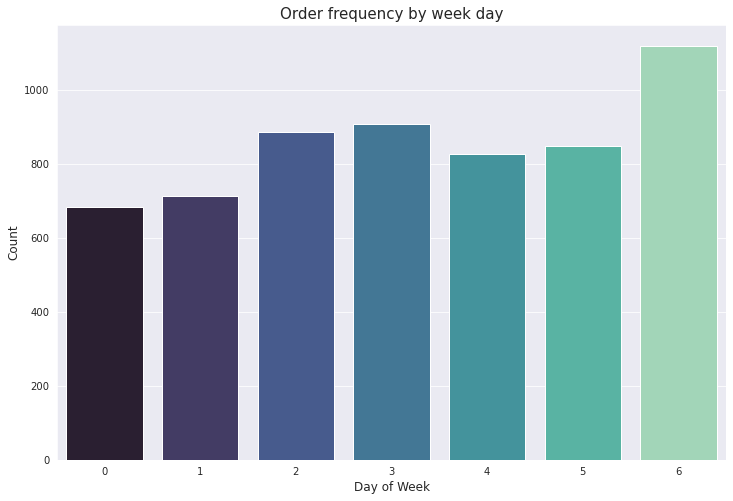

In [18]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12,8))
    sns.countplot(x="day_of_week", data=orders, palette='mako')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Day of Week', fontsize=12)
    plt.title("Order frequency by week day", fontsize=15)
    plt.show()

0 is Monday, so Sunday is the most popular day for delivery orders 

In [19]:
orders['delivery_started_hour'] = orders.when_the_delivery_started.dt.hour


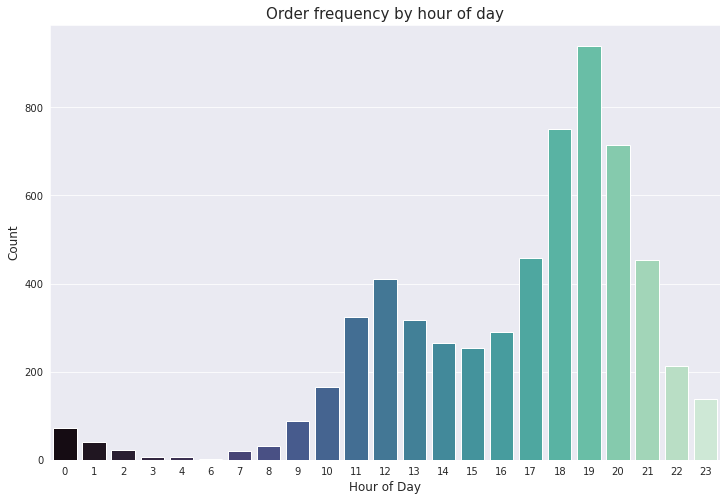

In [20]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12,8))
    sns.countplot(x="delivery_started_hour", data=orders, palette='mako')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.title("Order frequency by hour of day", fontsize=15)
    plt.show()

As expected, dinner time is the most popular time to order

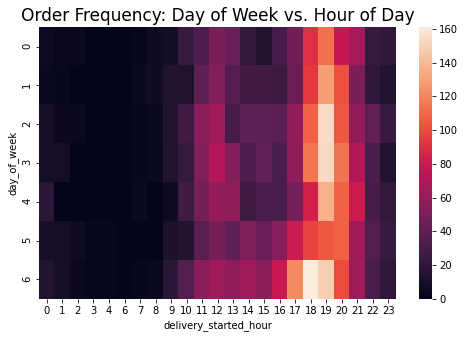

In [21]:
day_hour_grouped = orders.groupby(['day_of_week','delivery_started_hour'])['delivery_id'].count().reset_index()
day_hour_grouped = day_hour_grouped.pivot('day_of_week','delivery_started_hour','delivery_id')
day_hour_grouped = day_hour_grouped.fillna(0)

plt.figure(figsize=(8,5))
sns.heatmap(day_hour_grouped)
plt.title("Order Frequency: Day of Week vs. Hour of Day",fontsize=17)
plt.show()

# Merchant Analysis

Understand merchant performance and which merchants are fueling growth 

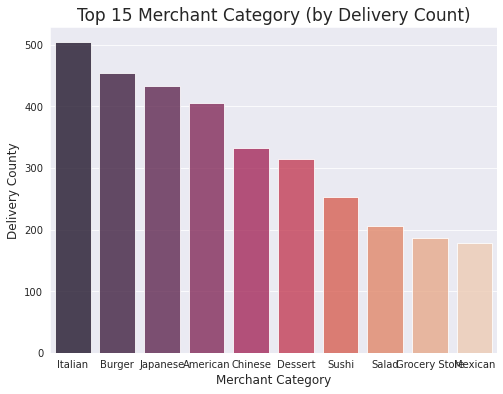

In [22]:
frequent_merchants = orders.groupby('place_category')['delivery_id'].count().sort_values(ascending=False).reset_index()
frequent_merchants = frequent_merchants.head(10)
frequent_merchants

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(8,6))
    sns.barplot(x=frequent_merchants.place_category, y=frequent_merchants.delivery_id, alpha=0.8, palette='rocket')
    plt.ylabel('Delivery County',size=12)
    plt.xlabel('Merchant Category', size=12)
    plt.title('Top 15 Merchant Category (by Delivery Count)',size=17)
    plt.show()

In [25]:
pickup_places = round(orders['pickup_place'].value_counts()/len(orders)*100,3)
pickup_places


Shake Shack           5.198
Momofuku Milk Bar     3.109
The Meatball Shop     3.075
Blue Ribbon Sushi     2.524
sweetgreen            2.490
                      ...  
Han's Deli            0.017
Cafe City Chow        0.017
The Capital Grille    0.017
460 park ave south    0.017
Little Creatures      0.017
Name: pickup_place, Length: 898, dtype: float64

In [27]:
cat_data = round((orders.place_category.value_counts())/len(orders.place_category)*100,3)
cat_data = cat_data[cat_data > 1.5]
cat_data

Italian          8.424
Burger           7.588
Japanese         7.237
American         6.769
Chinese          5.549
Dessert          5.265
Sushi            4.229
Salad            3.443
Grocery Store    3.126
Mexican          2.975
Bakery           2.340
BBQ              2.240
Pizza            1.772
Juice Bar        1.655
Indian           1.521
Donut            1.504
Name: place_category, dtype: float64

Most popular merchant categories are Italian, Burger and Japanese 

# Customer Analysis 

Identify repeat customers, which merchants/categories have the most repeat customers 

In [28]:
orders.customer_id.nunique()

3192

In [ ]:
repeat_customers = orders.groupby('customer_id')['delivery_id'].count().sort_values(ascending=False)
repeat_customers = repeat_customers[repeat_customers == 1]
len(repeat_customers)
print(len(repeat_customers)/orders.customer_id.nunique())

60% of customers have only ordered 1 delivery

Where are our frequent customers eating? 

In [ ]:
repeat_customers = orders.groupby(['place_category','customer_id'])['delivery_id'].count().sort_values(ascending=False)
repeat_customers = repeat_customers[repeat_customers > 4]
repeat_customers

In [ ]:
data = orders.groupby('customer_id')['delivery_id'].count().sort_values(ascending=False)
data = data[data >10]
data

plt.figure(figsize=(15,6))
sns.barplot(x=data.index, y=data.values, alpha=0.8, palette='rocket')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count',size=12)
plt.xlabel('Customer ID', size=12)
plt.title('Repeat Customers (10+ orders)',size=15)
plt.show()

# Jumpmen Travel Efficiency Analysis 

- Vehicle type efficiencies
- KPI around target turnaround for arrival to departure at restaurant

In [ ]:
#total trip
orders['total_trip'] = orders['when_the_Jumpman_arrived_at_dropoff'] - orders['when_the_delivery_started']
orders['total_trip'].describe()

Vehicle type trip efficiency

In [ ]:
bike_v_vehicle = orders.groupby(['vehicle_type'])['delivery_id'].count().sort_values(ascending=False)
bike_v_vehicle = bike_v_vehicle/len(orders)
bike_v_vehicle

In [ ]:
#leg1
orders['time_to_merchant'] = orders['when_the_Jumpman_arrived_at_pickup'] - orders['when_the_delivery_started']
orders['time_to_merchant'].describe()

In [ ]:
#leg2
orders['merchant_time_turnover'] = orders['when_the_Jumpman_left_pickup'] - orders['when_the_Jumpman_arrived_at_pickup']
orders['merchant_time_turnover'].describe()

In [ ]:
#leg3
orders['post_pickup_time_to_customer'] = orders['when_the_Jumpman_arrived_at_dropoff'] - orders['when_the_Jumpman_left_pickup']
orders['post_pickup_time_to_customer'].describe()

Average total time per delivery is 46 minutes. Average time for a jumpman to be at the restaurant is 18 minutes. Average time it took for jumpmen to get to the customer after leaving the restaurant is 14 minutes. 

In order to track efficiency KPIs, I recommend setting a target goal investigating instances where the time is exceeding the target metric. For example, for any instances that are above the 75 percentile, it would be useful to understand causes that led to these delays (order wasn't ready yet, order was incorrect, parking issues, etc). It is important to quantify delays in order to make accurate predictions on the app when customers are given an ETA for their delivery 

# Location Analysis

# Customer Locations (Map)

Where are the majority of our customers located? 

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

f = folium.Map(location=[40.7128, -74.0060],zoom_start=15)
folium.TileLayer('stamentoner').add_to(f)

Arr = orders[['dropoff_lat','dropoff_lon']].to_numpy()

f.add_child(plugins.HeatMap(Arr,radius=15))

f

# Restaurant Locations (Map)

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

f = folium.Map(location=[40.7128, -74.0060],zoom_start=15)
folium.TileLayer('stamentoner').add_to(f)

Arr = orders[['pickup_lat','pickup_lon']].to_numpy()

f.add_child(plugins.HeatMap(Arr,radius=15))

f